In [1]:
import numpy as np 
import plot_trajectory_2d as my_plt
import matplotlib.pyplot as plt
import oracles
import optimization
import seaborn as sns

sns.set(font_scale=1.5)

c:\Users\1\Desktop\прога\Метопты\cmc-mipt17-opt-course\task1\plot_trajectory_2d.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  CS = plt.contour(X, Y, Z, levels=levels, colors='k', linewidth=4.0)


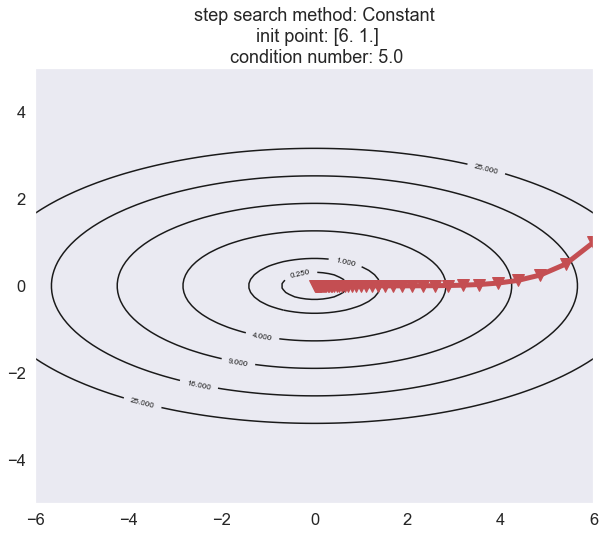

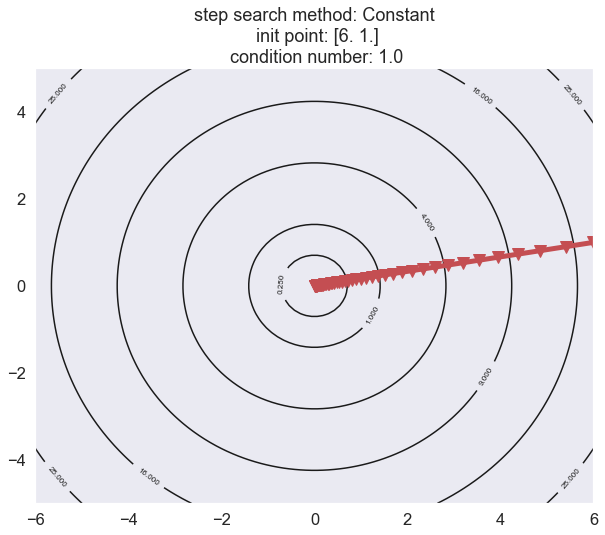

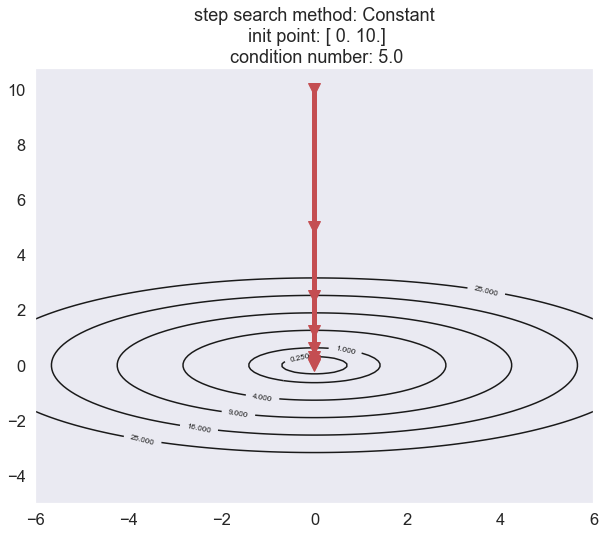

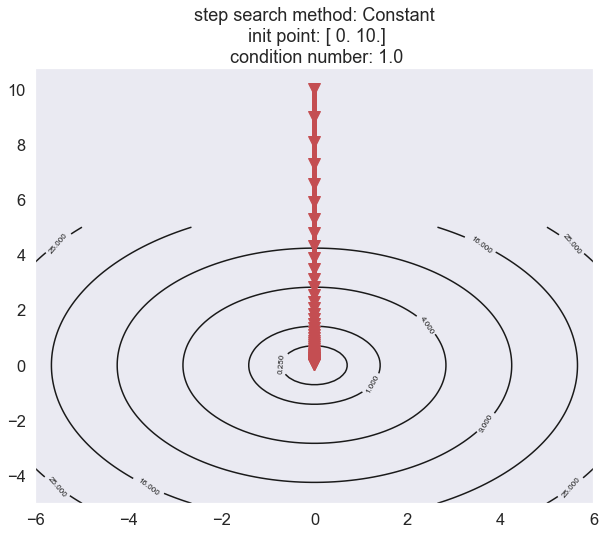

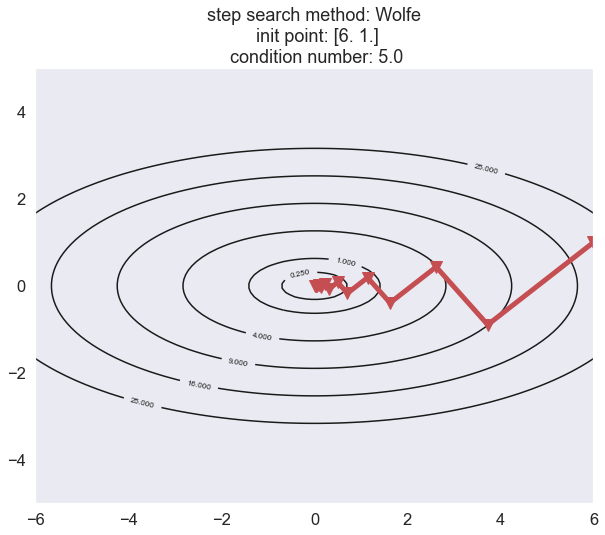

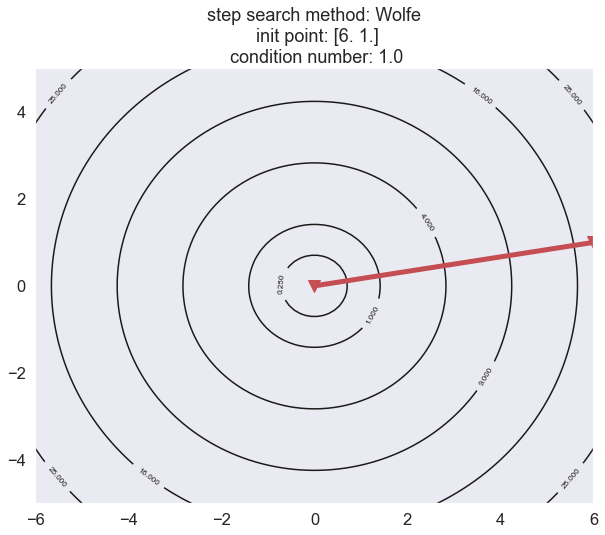

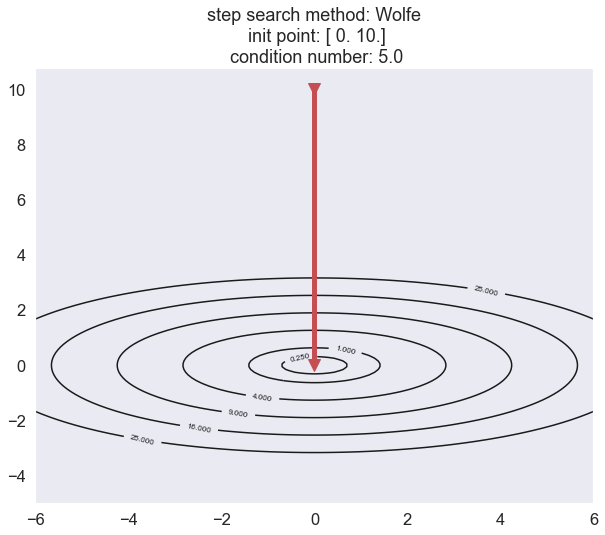

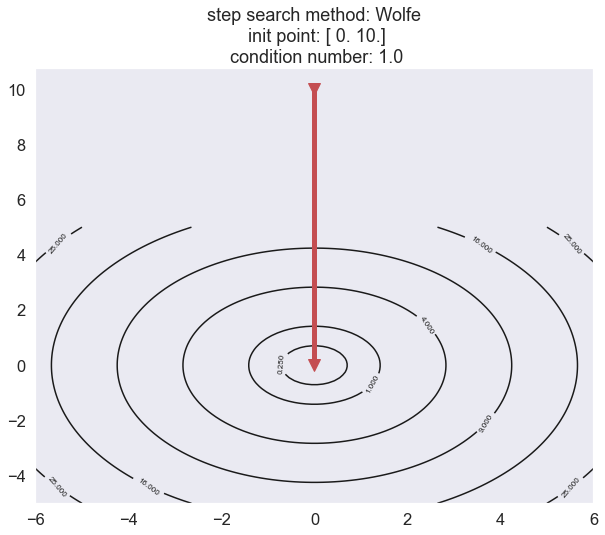

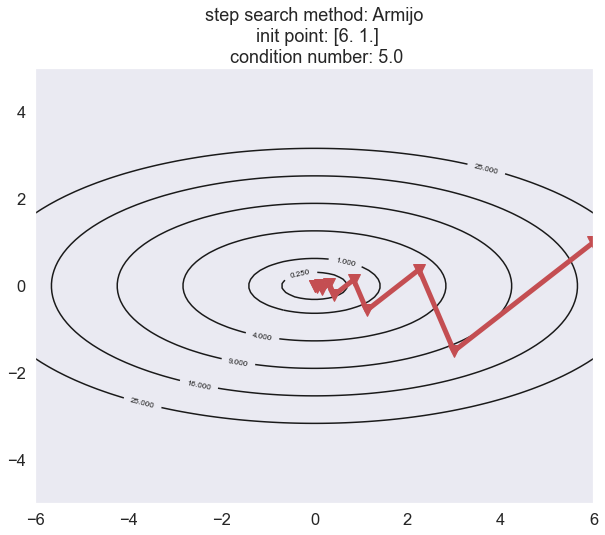

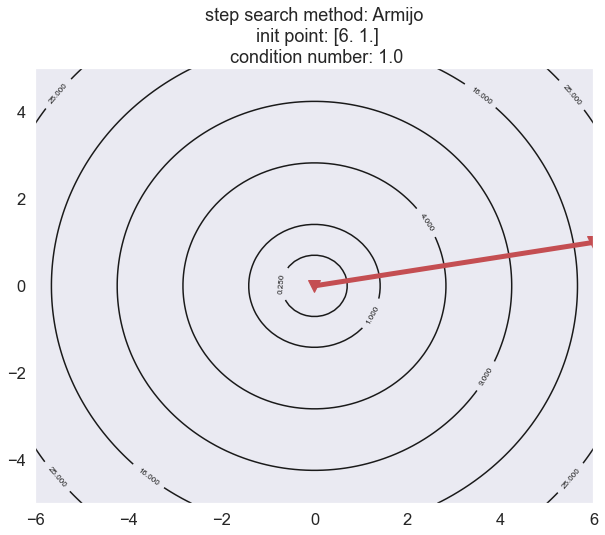

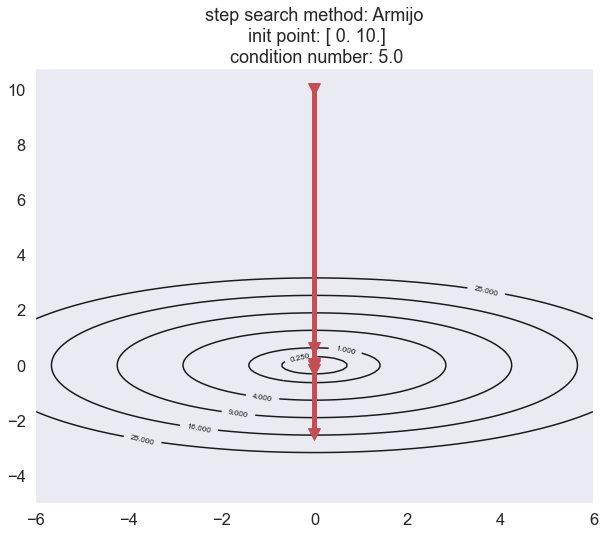

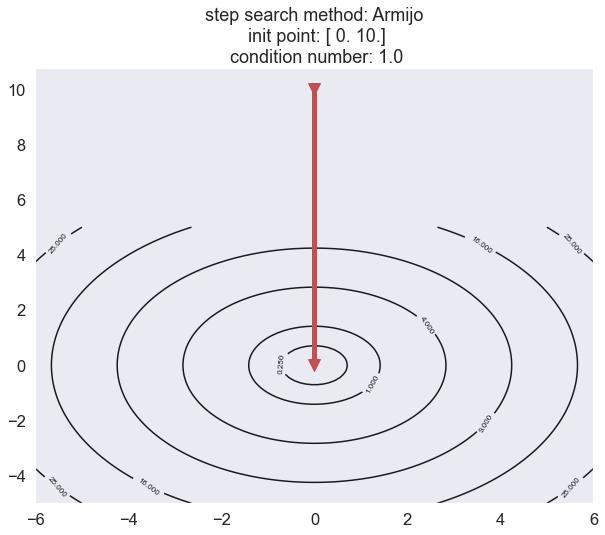

In [10]:
methods=["Constant", "Wolfe", "Armijo"]
init_points=np.array([[6.0, 1.0], [0.0, 10.0]])
matrixs = np.array([[[1.0, 0.0], [0.0, 5.0]], [[1.0, 0], [0, 1.0]]])
for method in methods:
    for init_point in init_points:
        for matr in matrixs:
            plt.figure(figsize=(10, 8))
            plt.title(f'step search method: {method}\n init point: {init_point}\n condition number: {matr[1][1]}')
            oracle = oracles.QuadraticOracle(matr, np.zeros(2))
            [x_star, msg, history] = optimization.gradient_descent(oracle, init_point, trace=True, line_search_options={'method': method, 'c': 0.1})
            my_plt.plot_levels(oracle.func)
            my_plt.plot_trajectory(oracle.func, history['x'])
            plt.savefig(f'images/{method}_{init_point}_{matr[1][1]}.png')
            plt.show()

In [4]:
from scipy.sparse import diags
def get_random_quad_problem(N, kappa):
    a = np.random.uniform(low=0, high=kappa - 1, size=N)
    a -= np.min(a)
    a *= (kappa - 1) / np.max(a)
    a += 1
    A = diags(a)
    b = np.random.uniform(-10, 10, N)
    return A, b

def get_iteration_num(N, kappa):
    A, b = get_random_quad_problem(N, kappa)
    oracle = oracles.QuadraticOracle(A, b)
    [x_star, msg, history] = optimization.gradient_descent(oracle, np.random.uniform(-10, 10, size=N), trace=True)
    return len(history['time'])

# get_random_quad_problem(10, 7)

In [5]:
dim_grid = [10, 100, 1000, 10000]
kappa_grid = np.linspace(2, 100, 100)
colors = ['r', 'b', 'g', 'purple']
experiment_cnt = 100
results = np.zeros(shape=(len(dim_grid), experiment_cnt, len(kappa_grid)))

for dim_i in range(len(dim_grid)):
    vector_iter_num = np.vectorize(lambda kappa: get_iteration_num(dim_grid[dim_i], kappa))
    for i in range(experiment_cnt):
        results[dim_i, i] = vector_iter_num(kappa_grid)

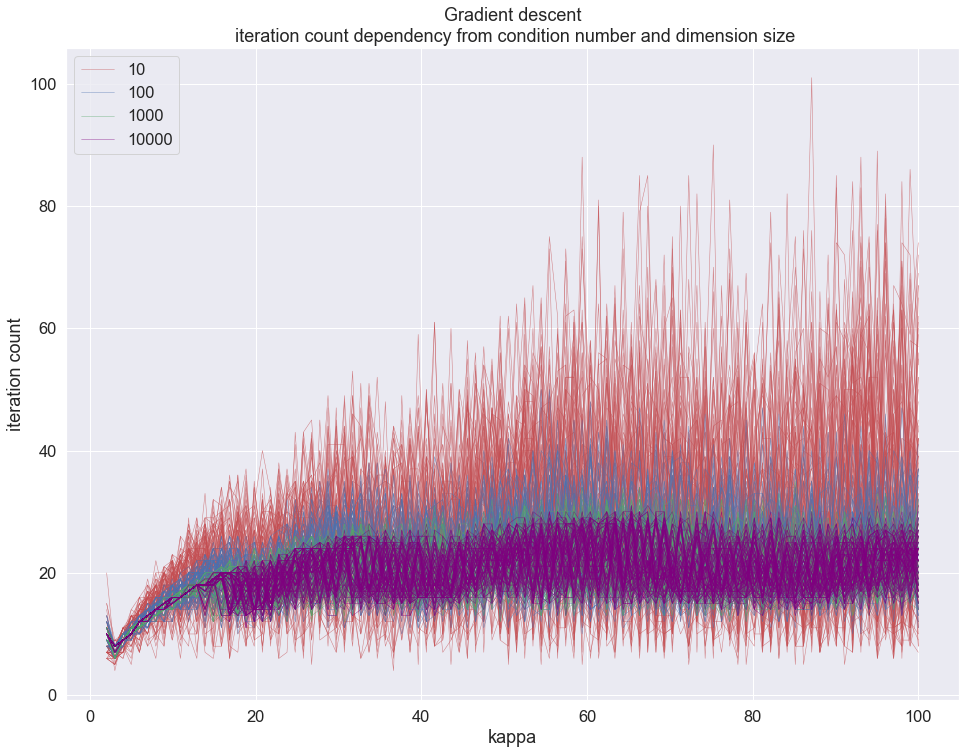

In [6]:
plt.figure(figsize=(16, 12))

# dim_grid = [10, 100, 1000, 10000]
# kappa_grid = np.linspace(2, 100, 100)
# colors = ['r', 'b', 'g', 'purple']
# experiment_cnt = 100
# results = np.zeros(shape=(len(dim_grid), experiment_cnt, len(kappa_grid)))
plt.title('Gradient descent\n iteration count dependency from condition number and dimension size')

for dim_i, color in enumerate(colors):
    for i in range(experiment_cnt):
        label = f'{dim_grid[dim_i]}' if i == 0 else ''
        plt.plot(kappa_grid, results[dim_i, i], c=color, alpha=0.7, label=label, lw=0.5)

plt.xlabel('kappa')
plt.ylabel('iteration count')
plt.legend()
plt.show()

In [8]:
from sklearn.datasets import load_svmlight_file

def draw_plot(data_file):
    data = load_svmlight_file(f'datasets/{data_file}')
    A = data[0]
    b = data[1]
    reg_coef = 1 / A.shape[0]
    oracle = oracles.create_log_reg_oracle(A, b, reg_coef)

    [x_star, msg, historyGD] = optimization.gradient_descent(oracle, np.zeros(A.shape[1]), trace=True)
    [x_star, msg, historyN] = optimization.newton(oracle, np.zeros(A.shape[1]), trace=True)

    historyGD['grad_norm'] = np.array(historyGD['grad_norm'])**2 / historyGD['grad_norm'][0]**2
    historyN['grad_norm'] = np.array(historyN['grad_norm'])**2 / historyN['grad_norm'][0]**2

    for plot_type in ['grad', 'func']:
        if plot_type == 'grad':
            ylabel = "grad norm"
            y_ax = 'grad_norm'
            log_scale=True
        elif plot_type == 'func':
            ylabel = "func value"
            y_ax='func'
            log_scale=False
        else:
            return None

        plt.figure(figsize=(12, 8))
        if log_scale:
            plt.yscale('log')
        plt.plot(historyGD['time'], historyGD[y_ax], label='gradient descent')
        plt.plot(historyN['time'], historyN[y_ax], label='newton')

        plt.title(f'{data_file} dataset, {ylabel} convergence')
        plt.xlabel('time, s')
        plt.ylabel(ylabel)
        plt.legend()
        plt.savefig(f'images/{data_file}_{ylabel}.png')
        print('saved: ', f'images/{data_file}_{ylabel}.png')
        plt.show()

    for field in ['time', 'func', 'grad_norm']:
        for plot_type in ['grad', 'func']:
            np.save(f"logs/{data_file}_{plot_type}_{field}_GD", historyGD[field])
            np.save(f"logs/{data_file}_{plot_type}_{field}_N", historyN[field])

    return historyGD, historyN

saved:  images/gisette_scale_grad norm.png


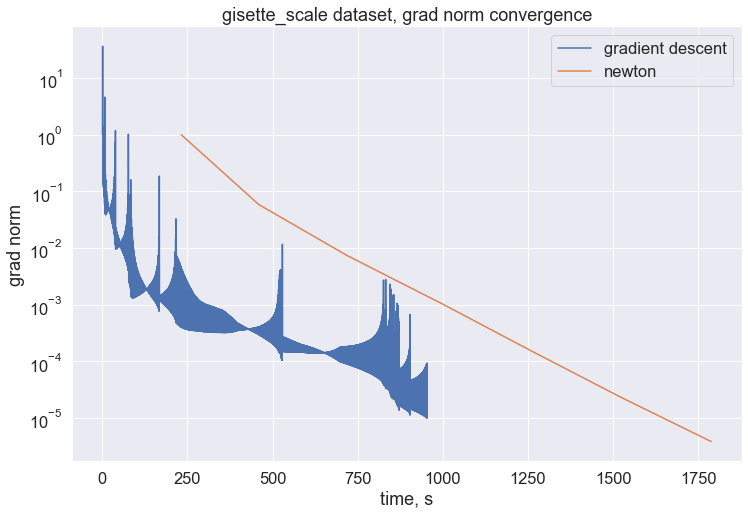

saved:  images/gisette_scale_func value.png


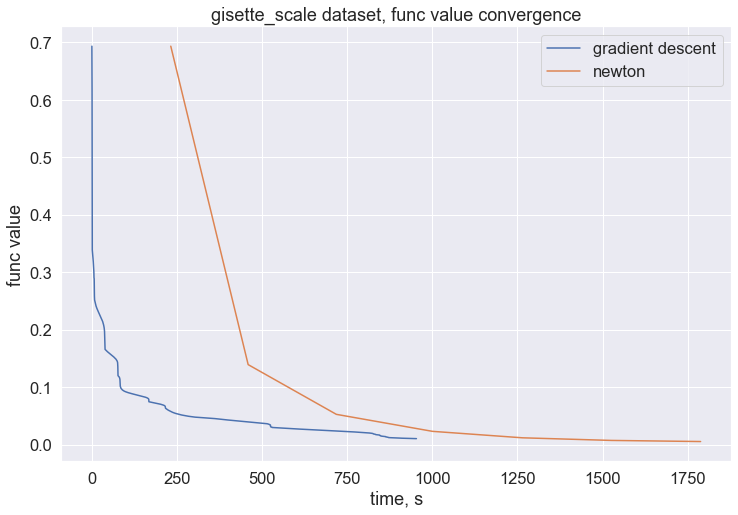

In [12]:
from importlib import reload
reload(oracles)

datasets = ['gisette_scale']
for data_file in datasets:
    historyGD, historyN = draw_plot(data_file)